In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
    
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
import os
import cooler
import cooltools
import numpy as np
from cooltools import eigdecomp
import bioframe
from pathlib import Path
import multiprocess as mp
import pandas as pd

from copy import copy

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# import all samples as dictionary ...
from samples import *


In [4]:
# ins_samples = {
#     "Hap1-WT-combined.hg19" : "Hap1-WT-combined.mcool",
# }

ins_samples = {
    #cooler locations, some expected at these locations
    # CTCF degron
    "CkoCT442_NT_pool.hg19" : "/data/alv/CTCF_degron/data/CkoCT442-NT-pool.mcool",
    "CkoCT442_IAA_pool.hg19" : "/data/alv/CTCF_degron/data/CkoCT442-IAA-pool.mcool",

    #polII degron
    "PolII-NT.hg19" : "/data/alv/polII_degron/data/20200417_remap_polIIdegron/coolers_library_group/PTB2539-NT.hg19.mapq_30.1000.mcool",
    "PolII-IAA.hg19" : "/data/alv/polII_degron/data/20200417_remap_polIIdegron/coolers_library_group/PTB2539-IAA.hg19.mapq_30.1000.mcool",

    #AAVS1 clone
    "mutControl-NT.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/CkoCT442-AAVS1-NT-pool.mcool",
    "mutControl-IAA.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/CkoCT442-AAVS1-IAA-pool.mcool",

    #DDX55 clones
    "mutDDX55-NT.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/DDX55-clones-NT.hg19.mapq_30.1000.mcool",
    "mutDDX55-IAA.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/DDX55-clones-IAA.hg19.mapq_30.1000.mcool",

    #TAF5L clones
    "mutTAF5L-NT.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/TAF5L-clones-NT.hg19.mapq_30.1000.mcool",
    "mutTAF5L-IAA.hg19" : "/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/TAF5L-clones-IAA.hg19.mapq_30.1000.mcool",

    #siCONTROL
    "siControl-NT.hg19" : "/data/alv/CTCF_degron/data/siCTRL-NT.hg19.mapq_30.1000.mcool",
    "siControl-IAA.hg19" : "/data/alv/CTCF_degron/data/siCTRL-IAA.hg19.mapq_30.1000.mcool",

    #siDDX55
    "siDDX55-NT.hg19" : "/data/alv/CTCF_degron/data/siDDX55-NT.hg19.mapq_30.1000.mcool",
    "siDDX55-IAA.hg19" : "/data/alv/CTCF_degron/data/siDDX55-IAA.hg19.mapq_30.1000.mcool",

    #siTAF5L
    "siTAF5L-NT.hg19" : "/data/alv/CTCF_degron/data/siTAF5L-NT.hg19.mapq_30.1000.mcool",
    "siTAF5L-IAA.hg19" : "/data/alv/CTCF_degron/data/siTAF5L-IAA.hg19.mapq_30.1000.mcool",

    #RAD21 degron
    "RAD21-NT.hg19" : "/data/alv/CTCF_degron/data/RAD21-AID-NT.hg19.mapq_30.1000.mcool",
    "RAD21-IAA.hg19" : "/data/alv/CTCF_degron/data/RAD21-AID-IAA-6H.hg19.mapq_30.1000.mcool",

    #PlaB splicing inhibition
    "CtrlPlaB-NT.hg19" : "/data/alv/CTCF_degron/data/NT-hg19-combined-90000000.mcool",
    "CtrlPlaB-IAA.hg19" : "/data/alv/CTCF_degron/data/IAA-hg19-combined-90000000.mcool",
    "PlaB-NT.hg19" : "/data/alv/CTCF_degron/data/NT-PlaB-hg19-combined-90000000.mcool",
    "PlaB-IAA.hg19" : "/data/alv/CTCF_degron/data/IAA-PlaB-hg19-combined-90000000.mcool",

    #compare with WT
    "Ctrl500M-noTIR1.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/Hap1-WT-combined-500000000.mcool",
    "Ctrl500M-wtHAP1.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/CkoC44-NO-TIR1-pool.mcool",
    "Ctrl500M-CT442-NT.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/CkoCT442-NT-pool-500000000.mcool",
    "Ctrl500M-CT442-IAA.hg19" : "/data/alv/CTCF_degron/data/WT-44-442-pool/CkoCT442-IAA-pool-500000000.mcool",
}

In [5]:
# ins_samples = {
#     "Hap1-WT-combined.hg19" : f"Hap1-WT-combined.mcool",
# }

binsize = 5_000
binsize_human = f"{int(binsize/1_000)}kb"


exp_samples = {
    #cooler locations, some expected at these locations
    # CTCF degron
    "CkoCT442_NT_pool.hg19" : f"/data/alv/CTCF_degron/data/CkoCT442-NT-pool.{binsize_human}.cis.exp.tsv",
    "CkoCT442_IAA_pool.hg19" : f"/data/alv/CTCF_degron/data/CkoCT442-IAA-pool.{binsize_human}.cis.exp.tsv",

    #polII degron
    "PolII-NT.hg19" : f"/data/alv/polII_degron/data/20200417_remap_polIIdegron/coolers_library_group/PTB2539-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "PolII-IAA.hg19" : f"/data/alv/polII_degron/data/20200417_remap_polIIdegron/coolers_library_group/PTB2539-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #AAVS1 clone
    "mutControl-NT.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/CkoCT442-AAVS1-NT-pool.{binsize_human}.cis.exp.tsv",
    "mutControl-IAA.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/CkoCT442-AAVS1-IAA-pool.{binsize_human}.cis.exp.tsv",

    #DDX55 clones
    "mutDDX55-NT.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/DDX55-clones-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "mutDDX55-IAA.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/DDX55-clones-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #TAF5L clones
    "mutTAF5L-NT.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/TAF5L-clones-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "mutTAF5L-IAA.hg19" : f"/data/alv/CTCF_degron/data/DDX55-TAF5L-ctrl-pool/TAF5L-clones-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #siCONTROL
    "siControl-NT.hg19" : f"/data/alv/CTCF_degron/data/siCTRL-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "siControl-IAA.hg19" : f"/data/alv/CTCF_degron/data/siCTRL-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #siDDX55
    "siDDX55-NT.hg19" : f"/data/alv/CTCF_degron/data/siDDX55-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "siDDX55-IAA.hg19" : f"/data/alv/CTCF_degron/data/siDDX55-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #siTAF5L
    "siTAF5L-NT.hg19" : f"/data/alv/CTCF_degron/data/siTAF5L-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "siTAF5L-IAA.hg19" : f"/data/alv/CTCF_degron/data/siTAF5L-IAA.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #RAD21 degron
    "RAD21-NT.hg19" : f"/data/alv/CTCF_degron/data/RAD21-AID-NT.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",
    "RAD21-IAA.hg19" : f"/data/alv/CTCF_degron/data/RAD21-AID-IAA-6H.hg19.mapq_30.1000.{binsize_human}.cis.exp.tsv",

    #PlaB splicing inhibition
    "CtrlPlaB-NT.hg19" : f"/data/alv/CTCF_degron/data/NT-hg19-combined-90000000.{binsize_human}.cis.exp.tsv",
    "CtrlPlaB-IAA.hg19" : f"/data/alv/CTCF_degron/data/IAA-hg19-combined-90000000.{binsize_human}.cis.exp.tsv",
    "PlaB-NT.hg19" : f"/data/alv/CTCF_degron/data/NT-PlaB-hg19-combined-90000000.{binsize_human}.cis.exp.tsv",
    "PlaB-IAA.hg19" : f"/data/alv/CTCF_degron/data/IAA-PlaB-hg19-combined-90000000.{binsize_human}.cis.exp.tsv",

    #compare with WT
    "Ctrl500M-noTIR1.hg19" : f"/data/alv/CTCF_degron/data/WT-44-442-pool/Hap1-WT-combined-500000000.{binsize_human}.cis.exp.tsv",
    "Ctrl500M-wtHAP1.hg19" : f"/data/alv/CTCF_degron/data/WT-44-442-pool/CkoC44-NO-TIR1-pool.{binsize_human}.cis.exp.tsv",
    "Ctrl500M-CT442-NT.hg19" : f"/data/alv/CTCF_degron/data/WT-44-442-pool/CkoCT442-NT-pool-500000000.{binsize_human}.cis.exp.tsv",
    "Ctrl500M-CT442-IAA.hg19" : f"/data/alv/CTCF_degron/data/WT-44-442-pool/CkoCT442-IAA-pool-500000000.{binsize_human}.cis.exp.tsv",
}

In [6]:
all_genes = pd.read_table(
    "annotated_genes_for_pileups.bed",
    header=None,
    names=["chrom","start","end","strand","exp","size"]
)

### Let's exclude genes that have CTCF within 2kb of TSS ...

In [7]:
from copy import copy
ctcf_df = bioframe.read_table(
        "NT-CTCF-narrowPeaks-sort-merge-with-strength.bed",
        schema="bed3",
        index_col=False
)

ctcf_radius = 2_000
_tss = copy(all_genes)
_tss["tss"] = _tss.apply(lambda r: r["start"] if r["strand"]=="+" else r["end"],axis=1)
_tss["tss_mflank"] = _tss["tss"] - ctcf_radius
_tss["tss_pflank"] = _tss["tss"] + ctcf_radius
# _tss[["chrom","tss_mflank","tss_pflank"]]

tss_ctcf_overlap = bioframe.overlap(
    _tss[["chrom","tss_mflank","tss_pflank"]],
    ctcf_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tss_mflank","tss_pflank"],
)


_tts = copy(all_genes)
_tts["tts"] = _tts.apply(lambda r: r["end"] if r["strand"]=="+" else r["start"],axis=1)
_tts["tts_mflank"] = _tts["tts"] - ctcf_radius
_tts["tts_pflank"] = _tts["tts"] + ctcf_radius
# _tts[["chrom","tss_mflank","tss_pflank"]]

tts_ctcf_overlap = bioframe.overlap(
    _tts[["chrom","tts_mflank","tts_pflank"]],
    ctcf_df,
    how='left',
    suffixes=('_', ''),
    return_index=True,
    # keep_order=False,
    cols1=["chrom","tts_mflank","tts_pflank"],
)



# .drop_duplicates(subset=["chrom_","tss_mflank_","tss_pflank_"])

In [8]:
ctcf_index = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TSS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

5063 genes have CTCF@TSS,
    17231 genes do not -
    total # of genes 22294


<ipython-input-8-bc1c4dc09ff1>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctcf_index = np.unique(ctcf_index.astype(np.int).values)
<ipython-input-8-bc1c4dc09ff1>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated 

#### same for TTS ...

In [9]:
ctcf_index = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
ctcf_index = np.unique(ctcf_index.astype(np.int).values)
noctcf_index = np.unique(noctcf_index.astype(np.int).values)

all_genes_ctcf = all_genes.loc[ ctcf_index ].reset_index(drop=True)
all_genes_noctcf = all_genes.loc[ noctcf_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_ctcf)} genes have CTCF@TTS,
    {len(all_genes_noctcf)} genes do not -
    total # of genes {len(all_genes_noctcf)+len(all_genes_ctcf)}"""
)

2568 genes have CTCF@TTS,
    19726 genes do not -
    total # of genes 22294


<ipython-input-9-f1cfe83891fd>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctcf_index = np.unique(ctcf_index.astype(np.int).values)
<ipython-input-9-f1cfe83891fd>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated 

#### combine TSS and TTS - without CTCF

In [10]:
ctcf_index_tts = tts_ctcf_overlap["index_"][
                    ~pd.isna(tts_ctcf_overlap["index"])
                ]
noctcf_index_tts = tts_ctcf_overlap["index_"][
                    pd.isna(tts_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TTS
ctcf_index_tts = np.unique(ctcf_index_tts.astype(np.int).values)
noctcf_index_tts = np.unique(noctcf_index_tts.astype(np.int).values)


ctcf_index_tss = tss_ctcf_overlap["index_"][
                    ~pd.isna(tss_ctcf_overlap["index"])
                ]
noctcf_index_tss = tss_ctcf_overlap["index_"][
                    pd.isna(tss_ctcf_overlap["index"])
                ]
# these are indices of the genes (from all_genes) that have (don't have) CTCF@TSS
ctcf_index_tss = np.unique(ctcf_index_tss.astype(np.int).values)
noctcf_index_tss = np.unique(noctcf_index_tss.astype(np.int).values)

# here is the strictest set - no CTCF at TSS AND TTS ...
strict_index = np.intersect1d(
                        noctcf_index_tts,
                        noctcf_index_tss
                )

all_genes_noctcf_atall = all_genes.loc[ strict_index ].reset_index(drop=True)

print(
    f"""{len(all_genes_noctcf_atall)} genes have no CTCF@TTS and no CTCF@TSS"""
)

15710 genes have no CTCF@TTS and no CTCF@TSS


<ipython-input-10-ad407706de77>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ctcf_index_tts = np.unique(ctcf_index_tts.astype(np.int).values)
<ipython-input-10-ad407706de77>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
D

### Use `gdf` variable to choose which DataFrame with genes we are going to work on  ....

In [11]:
gdf = copy(all_genes_noctcf_atall)

#### Classify genes into discrete categories by gene-size and expression-level ...

In [12]:
exp_bin_edges = [0,.5,10,np.inf]
exp_labels = ("no","low","high")
sizes_bin_edges = [0,50_000,np.inf]
sizes_labels = ("short","long")

gdf["gexp"] = pd.cut(
    gdf["exp"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head())
display( gdf.groupby(["gexp","gsize"]).size().unstack(fill_value=0) )

,chrom,start,end,strand,exp,size,gexp,gsize
0,chr1,14361,29370,-,32,15009,high,short
1,chr1,69090,70008,+,0,918,no,short
2,chr1,134772,140566,-,0,5794,no,short
3,chr1,562759,564389,-,0,1630,no,short
4,chr1,752750,755214,+,0,2464,no,short


gsize,short,long
gexp,,
no,7208,1669
low,1544,948
high,2954,1387


### Let's use coolpup as Python API ...

In [13]:
from matplotlib.colors import LogNorm
# https://stackoverflow.com/questions/48625475/python-shifted-logarithmic-colorbar-white-color-offset-to-center
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self, vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

#### we'll use regions to make use of "proper" expected ...

In [14]:
# Use bioframe to fetch the genomic features from the UCSC.
hg19_chromsizes = bioframe.fetch_chromsizes('hg19', as_bed=True)
hg19_cens = bioframe.fetch_centromeres('hg19')
hg19_arms = bioframe.split(hg19_chromsizes, hg19_cens, cols_points=['chrom', 'mid'])

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
hg19_chromsizes = hg19_chromsizes.set_index("chrom").loc[autosomal_chroms].reset_index() 
hg19_arms = hg19_arms.set_index("chrom").loc[autosomal_chroms].reset_index()
# call this to automaticly assign names to chromosomal arms:
hg19_arms = bioframe.from_any(hg19_arms)
hg19_arms["name"] = [f"{chrom}{arm}" for chrom in autosomal_chroms for arm in list('pq')]

In [15]:
# import standard python libraries
import seaborn as sns
# import libraries for biological data analysis
import coolpuppy as cp
import cooler
import bioframe
# import cooltools
# import cooltools.expected
# from cooltools.lib import plotting

In [16]:
# ooe - Explanations and reminder ...
# (default)False: (o1 +o2 +o3 ... oN)/(e1+e2+e3+...eN) [shifting-normalization gose according to this scenraio as well]
# True: o1/e1 +o2/e2 +o3/e3 ... oN/eN

In [17]:
def get_pup(sites, clr, resolution, exp_df, regions_df):
    """
    generate scaled local pile-up for a collection of sites for a given
    cooler (clr) at a given resolution - keeping the padding size equal
    to the interval itself.
    """
    _sites = sites[["chrom","start","end","strand"]].reset_index(drop=True)
    cc = cp.CoordCreator(
        _sites,
        resolution=resolution,
        basetype='bed',
        local=True,
        fraction_pad=1.
    )
    pu = cp.PileUpper(
        clr,
        cc,
        control = True,
        rescale = True,
        rescale_size = 199,
    )
    #     pu = cp.PileUpper(
    #         clr,
    #         cc,
    #         regions= regions_df,
    #         expected = exp_df,
    #         ooe = True,
    #         control = False,
    #         rescale = True,
    #         rescale_size = 199,
    #     )
    print(f"working on a group of {len(_sites)} size ...")
    pup = pu.pileupsByStrandWithControl(nproc=18)
    return pup


In [18]:
# key_samples = ["Ctrl500M-CT442-NT.hg19"]#, "Ctrl500M-CT442-IAA.hg19"]

key_samples = ["CkoCT442_NT_pool.hg19",
                "CkoCT442_IAA_pool.hg19",
                "PolII-NT.hg19",
                "PolII-IAA.hg19",
                "mutControl-NT.hg19",
                "mutControl-IAA.hg19",
                "mutDDX55-NT.hg19",
                "mutDDX55-IAA.hg19",
                "mutTAF5L-NT.hg19",
                "mutTAF5L-IAA.hg19",
                "siControl-NT.hg19",
                "siControl-IAA.hg19",
                "siDDX55-NT.hg19",
                "siDDX55-IAA.hg19",
                "siTAF5L-NT.hg19",
                "siTAF5L-IAA.hg19",
                "RAD21-NT.hg19",
                "RAD21-IAA.hg19",
                "CtrlPlaB-NT.hg19",
                "CtrlPlaB-IAA.hg19",
                "PlaB-NT.hg19",
                "PlaB-IAA.hg19",
                "Ctrl500M-noTIR1.hg19",
                "Ctrl500M-wtHAP1.hg19",
                "Ctrl500M-CT442-NT.hg19",
                "Ctrl500M-CT442-IAA.hg19"]

pup_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["gexp","gsize"])
for sample in key_samples:
    print(f"working on {sample} ...")
    cname = ins_samples[sample]
    exp_name = exp_samples[sample]
    clr = cooler.Cooler(f"{cname}::/resolutions/{binsize}")
    exp_df = pd.read_csv(exp_name, sep="\t")
    pup_dict[sample] = gene_groups.apply( lambda sub_df: get_pup(sub_df, clr, binsize, exp_df, hg19_arms) )

working on CkoCT442_NT_pool.hg19 ...
working on a group of 7208 size ...
working on a group of 1669 size ...
working on a group of 1544 size ...
working on a group of 948 size ...
working on a group of 2954 size ...
working on a group of 1387 size ...
working on CkoCT442_IAA_pool.hg19 ...
working on a group of 7208 size ...
working on a group of 1669 size ...
working on a group of 1544 size ...
working on a group of 948 size ...
working on a group of 2954 size ...
working on a group of 1387 size ...
working on PolII-NT.hg19 ...
working on a group of 7208 size ...
working on a group of 1669 size ...
working on a group of 1544 size ...
working on a group of 948 size ...
working on a group of 2954 size ...
working on a group of 1387 size ...
working on PolII-IAA.hg19 ...
working on a group of 7208 size ...
working on a group of 1669 size ...
working on a group of 1544 size ...
working on a group of 948 size ...
working on a group of 2954 size ...
working on a group of 1387 size ...
workin

#### Save all of the results on disk using pickle - to avoid re-running it again

In [19]:
import pickle
file_to_store = open("PUP_DICT_5kb_SHIFT_EXP_4exp-size-groups.pickle", "wb")
pickle.dump(pup_dict, file_to_store)
# Save object to file
file_to_store.close()

In [20]:
# ! readlink -f PUP_DICT_5kb_SHIFT_EXP.pickle

### plotting different pileups for different groups ...

In [21]:
from matplotlib import colors

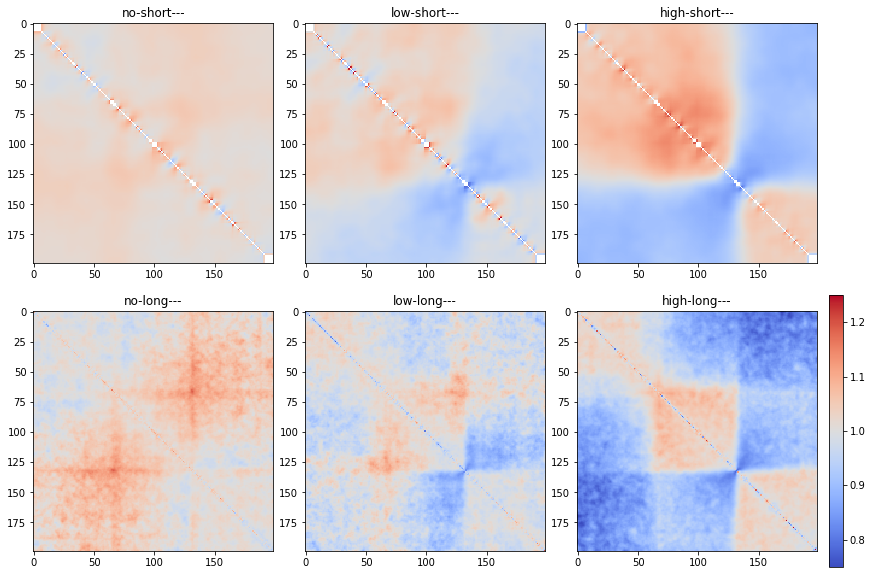

In [24]:
glens=("short","long")
gexps=("no","low","high")


fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))
orient="--"

_yyyy = pup_dict["CkoCT442_IAA_pool.hg19"].reset_index().set_index(["gexp","gsize","orientation"])

# divnorm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25)

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        pup_heatmap = _yyyy.loc[(gexp,glen,orient),"data"]
        img = ax.imshow(
            pup_heatmap,
#             norm = MidPointLogNorm(vmin=0.4,vmax=1.1,midpoint=1),
            norm = colors.TwoSlopeNorm(vmin=0.75, vcenter=1, vmax=1.25),
            cmap="coolwarm",
            interpolation="nearest",            
        )
        ax.set_title(f"{gexp}-{glen}-{orient}") 
plt.colorbar(img)